In [1]:
!nvidia-smi


Sun Nov  7 05:55:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [4]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':128, 'width':128, 'channels':3}

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

In [7]:
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [8]:
import os

In [9]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [01:11<00:00, 56.1MB/s]


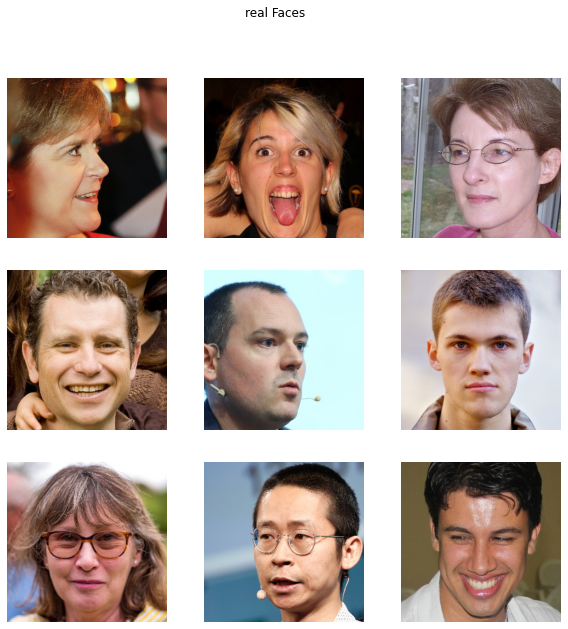

In [10]:
path = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show()

In [11]:
bs = 64
row, col = 128, 128
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [12]:
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (128, 128, 3)),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.5),

    #  tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(2, activation='softmax')
     ]
)


In [13]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot


In [14]:
tf.keras.utils.pydot = pydot

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [20]:
epochs = 10
batch_size = 100
init_lr = 1e-5
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/MiniNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.001,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [27]:
%%time
history = model.fit(training_set, validation_data = validation_set, epochs = epochs, validation_steps = 100, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.0537 - accuracy: 0.9807 - val_loss: 0.1651 - val_accuracy: 0.9600
Epoch 2/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.0546 - accuracy: 0.9804 - val_loss: 0.1531 - val_accuracy: 0.9563
Epoch 3/10
1563/1563 [==============================] - 196s 126ms/step - loss: 0.0518 - accuracy: 0.9818 - val_loss: 0.1639 - val_accuracy: 0.9522
Epoch 4/10
1563/1563 [==============================] - 199s 127ms/step - loss: 0.0543 - accuracy: 0.9810 - val_loss: 0.1345 - val_accuracy: 0.9633
Epoch 5/10
1563/1563 [==============================] - 197s 126ms/step - loss: 0.0494 - accuracy: 0.9824 - val_loss: 0.1601 - val_accuracy: 0.9602
Epoch 6/10
1563/1563 [==============================] - 197s 126ms/step - loss: 0.0537 - accuracy: 0.9815 - val_loss: 0.1405 - val_accuracy: 0.9577
Epoch 7/10
1563/1563 [==============================] - 198s 127ms/step - loss: 0.0497 - accuracy: 0.9822 - val_

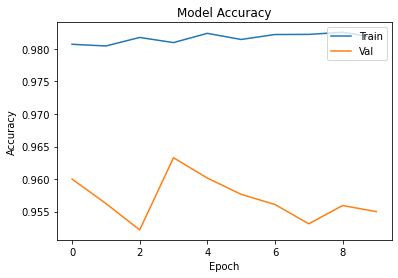

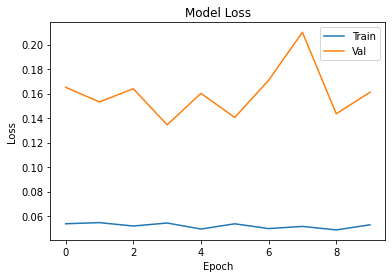

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(test_set)

313/313 [==============================] - 50s 160ms/step - loss: 0.1727 - accuracy: 0.9556


**Model Architecture**

In [ ]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot

In [ ]:
tf.keras.utils.pydot = pydot

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [30]:
dataset_url = "https://www.kaggle.com/sophatvathana/casia-dataset"

In [31]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 5.22G/5.22G [01:35<00:00, 58.5MB/s]


In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [33]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [34]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [35]:

image_size = (128, 128)

In [36]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [39]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [40]:
import random
path = '/content/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [41]:

path = '/content/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [44]:

#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [45]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [46]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [47]:

epochs = 50
batch_size = 64

In [48]:
init_lr = 1e-3
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [49]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/MiniNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.15, 
                              patience=8, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [52]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [53]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                 verbose = 1, 
                callbacks = callbacks)

Epoch 1/50
53/53 [==============================] - 3s 40ms/step - loss: 0.7533 - accuracy: 0.6584 - val_loss: 0.4054 - val_accuracy: 0.8367

Epoch 00001: val_loss improved from inf to 0.40545, saving model to /content/Model_weights/MiniNet.h5
Epoch 2/50
53/53 [==============================] - 2s 29ms/step - loss: 0.4298 - accuracy: 0.8271 - val_loss: 0.3384 - val_accuracy: 0.8752

Epoch 00002: val_loss improved from 0.40545 to 0.33841, saving model to /content/Model_weights/MiniNet.h5
Epoch 3/50
53/53 [==============================] - 1s 28ms/step - loss: 0.3472 - accuracy: 0.8682 - val_loss: 0.2978 - val_accuracy: 0.9016

Epoch 00003: val_loss improved from 0.33841 to 0.29784, saving model to /content/Model_weights/MiniNet.h5
Epoch 4/50
53/53 [==============================] - 1s 28ms/step - loss: 0.3012 - accuracy: 0.8901 - val_loss: 0.2916 - val_accuracy: 0.8956

Epoch 00004: val_loss improved from 0.29784 to 0.29156, saving model to /content/Model_weights/MiniNet.h5
Epoch 5/50
5

In [54]:

model.save('MiniNet_Model.h5')

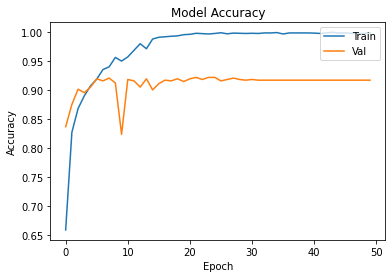

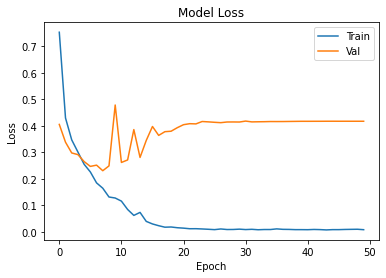

In [55]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [56]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

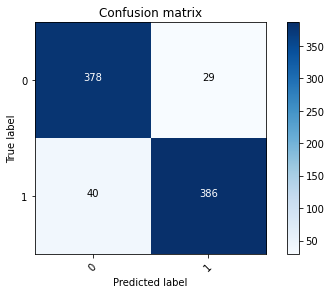

In [57]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [58]:
class_names = ['fake', 'real']

In [59]:
fake_image = os.listdir('/content/casia-dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/casia-dataset/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

In [60]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2035, Acc: 98.59496124031007


In [61]:
real_image = os.listdir('/content/casia-dataset/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/casia-dataset/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


In [62]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6760, Acc: 91.92276312211042
Total: 9418, Correct: 8795, Acc: 93.38500743257592
